Visualisation des différentes statistiques de Dbnary
=============

In [1]:
# RDF
import rdflib
from rdflib.namespace import *

# Data analys 
import numpy as np

#  PLotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from ipywidgets import Layout, Box, HBox, VBox
sns.set_theme(style="darkgrid")

from IPython.display import display, Markdown, clear_output

import warnings
warnings.filterwarnings("ignore")

ENDPOINT: str = "http://kaiko.getalp.org/sparql"

### Fonction qui retourne un DataFrame des résultats d'une requête SPARQL

In [2]:
# %load ../../src/SPARQL_query
import time as tm
from typing import NoReturn

import pandas as pd
from SPARQLWrapper import SPARQLWrapper
from ipywidgets import widgets


class SPARQLquery:
    """
    Class allowing to make a query on a remote SPARQL server, its main characteristics are :
     - Taking into account the big answers by concatenating them as they are received
     - Ability to access the size of the database
     - Ability to retrieve the response in `pandas` data frame format
    """

    def __init__(self, endpoint: str, query: str, verbose: bool = False, step: int = 1000,
                 widget: widgets.IntProgress = None) -> NoReturn:
        """


        :param endpoint: Url to the remote SPARQL service
        :param query: The query
        :param verbose: If the detail text will be displayed
        :param step: The max number of result to receive
        """
        self.sparql = SPARQLWrapper(endpoint)
        self.sparql.setReturnFormat("json")

        self.query: str = query
        self.verbose: bool = verbose
        self.step: int = step
        self.resultSize: int = self.get_result_size()
        self.is_widget: bool = False

        if widget:
            self.widget = widget
            self.widget.max = self.resultSize
            self.widget.value = 0
            self.is_widget = True

    def get_result_size(self) -> int:
        """
        Function return the size of a query (only in SELECT query)
        """

        if self.query.strip().startswith("SELECT") or self.query.strip().startswith(
                "select"):  # Modifie the query to count the number of answer

            if self.verbose:
                print(tm.strftime(f"[%H:%M:%S] Obtention du nombre de résultats avant exécuter la requête"))

            start: int = 7  # We detect the position of the first variable after the select
            while self.query[start] != '?':
                start += 1
            end: int = start
            while self.query[end:end + 5] != "WHERE" and self.query[end:end + 5] != "where":
                end += 1

            mot: str = self.query[start: end - 1]  # THe name of the variable

            self.sparql.setQuery(self.query.replace(mot, f"(COUNT (*) as ?cnt)", 1))
            processed_results: dict = self.sparql.query().convert()  # Do the query
            number_of_results: int = int(processed_results['results']['bindings'][0]['cnt']['value'])

            if self.verbose:
                print(tm.strftime(f"[%H:%M:%S] Il y a  {number_of_results} résultats..."))

            return number_of_results
        return 1

    def get_sparql_dataframe(self, query: str, text: str = "") -> pd.DataFrame:
        """
        Helper function to convert SPARQL results into a Pandas data frame.

        Credit: Douglas Fils

        :param query: The query to perform
        :param text: optional text to print in verbose mode
        """

        if self.verbose:
            print(tm.strftime(f"[%H:%M:%S] Transmission {text} en cours..."), end='')

        self.sparql.setQuery(query)

        processed_results: dict = self.sparql.query().convert()

        if self.verbose:
            print(tm.strftime(f"\r[%H:%M:%S] Transmission {text} réussi, conversion en Data Frame..."), end='')

        cols = processed_results['head']['vars']

        out = [[row.get(c, {}).get('value') for c in cols] for row in processed_results['results']['bindings']]

        if self.is_widget:
            if text == "":
                self.widget.value = self.widget.max
            else:
                self.widget.value = int(text.split(' ')[0])

        if self.verbose:
            print(tm.strftime(f" Effectué"))

        return pd.DataFrame(out, columns=cols)

    def do_query(self) -> pd.DataFrame:

        if self.resultSize > self.step:
            query = self.query + f" LIMIT {self.step}"
            return pd.concat(
                [self.get_sparql_dataframe(query + f" OFFSET {value}", f"{value} sur {self.resultSize}") for value in
                 range(0, self.resultSize, self.step)])
        return self.get_sparql_dataframe(self.query)


### On commence par chercher tout les différents types de datasets

In [3]:
def get_datasets(endpoint: str, query: str, verbose: bool = False, widget: widgets.IntProgress = None):
    if verbose:
        print(tm.strftime(f"[%H:%M:%S] Requête au serveur des différents datasets disponible... "))
    
    list_datasets = SPARQLquery(ENDPOINT, query, verbose=verbose, widget=widget).do_query()  # We recovers all DataSets Structure
        
    if verbose:    
        print(tm.strftime(f"[%H:%M:%S] Il y a {len(list_datasets)} datasets disponibles"))
        
    return list_datasets

ui = widgets.IntProgress(bar_style='success', description='Loading:',)
display(ui)

list_datasets = get_datasets(ENDPOINT, """SELECT ?dataset ?commentaire WHERE {?dataset a qb:DataSet ; rdfs:comment ?commentaire}""", verbose = False, widget = ui)
list_datasets_short = list_datasets['dataset'].map(lambda x: x.split('/')[-1]).to_frame().join(list_datasets['commentaire'].to_frame())
list_datasets_short

IntProgress(value=0, bar_style='success', description='Loading:')

,dataset,commentaire
0,dbnaryNymRelationsCube,The Data Cube containing observations on nym r...
1,dbnaryStatisticsCube,The Data Cube containing general observations ...
2,dbnaryTranslationsCube,The Data Cube containing observations on trans...
3,enhancementConfidenceDataCube,The Data Cube containing the confidence measur...
4,translationGlossesCube,The Data Cube containing observations on gloss...


### On va proposer à l'utilisateur de choisir quel dataset télécharger

In [92]:
DataFrame = pd.DataFrame()

output = widgets.Output()

dataset_user_choice = widgets.Dropdown(options = [(name, full_name) for name, full_name in zip(list_datasets_short['dataset'].values.reshape(-1),
                                                                                               list_datasets['dataset'].values.reshape(-1))], 
                                       description="Choix:", layout=Layout(flex='1 3 auto', width='auto'))
user_choice_confirm = widgets.Button(description='Soumettre', icon='check', layout=Layout(flex='1 1 auto', width='auto'),
                                     tooltip = "Cliquer ici pour confirmer votre choix")
description = widgets.Label(value=f"Description: {list_datasets[list_datasets['dataset'] == dataset_user_choice.value]['commentaire'].values[0]}",
                            layout=Layout(flex='1 1 auto', width='auto'))



items = [dataset_user_choice, user_choice_confirm]

box_layout = Layout(display='flex', flex_flow='row', align_items='stretch', width='90%')

                            
line_1 = Box(children=items, layout=box_layout)
line_2 = Box(children=[description], layout=box_layout)
ui = VBox([line_1, line_2])



def user_choice_change(obj):
    description.value=f"Description: {list_datasets[list_datasets['dataset'] == dataset_user_choice.value]['commentaire'].values[0]}"


def user_choice_confirm_eventhandler(obj):
    choice: str = dataset_user_choice.value
    with output:
        clear_output()
        output2 = widgets.Output()
        display(Markdown(data="#### Les différentes catégories de ce dataset sont: "))
        progress_bar = widgets.IntProgress(bar_style='success', description='Loading:')
        display(progress_bar)
        categories_long = SPARQLquery(ENDPOINT, f"""DESCRIBE ?item WHERE {'{'}?item qb:dataSet <{choice}> {'}'} LIMIT 1""", 
                                      verbose = False, widget = progress_bar).do_query()['p'].to_frame(name=None).set_axis(["Caractéristiques"], axis=1)
        categories_short = pd.DataFrame(categories_long["Caractéristiques"].map(lambda x: x.split('#')[-1]))
        progress_bar.close()
        
        display(categories_short)
        
        select = widgets.SelectMultiple(options=[(name, full_name) for name, full_name in zip(categories_short.values.reshape(-1), categories_long.values.reshape(-1))], 
                                        description='Critères: ', disabled=False, layout=Layout(flex='1 1 auto', width='auto', height = "auto"),
                                        style={'description_width': 'initial'})
        select_box = Box(children=[select], layout=box_layout)
        display(Markdown("####  Veuillez choisir au moins deux critères à télécharger:"))
        select_confirm = widgets.Button(description='Soumettre', icon='check', layout=Layout(flex='1 1 auto', width='auto'),
                                     tooltip = "Cliquer ici pour confirmer votre choix")
        select_confirm_box = Box(children=[select_confirm], layout=box_layout)
        select_ui = VBox([select_box, select_confirm_box])
        
        def selection_confirm_eventhandler(obj):
            selection = select.value
            with output2:
                if len(selection) >= 2: # We will constuct the query
                    global DataFrame
                    clear_output()
                    query: str = "SELECT "
                    vars_list: list[str] = [item.split('#')[-1] for item in selection]
                    for item in vars_list:
                        query += f"?{item} "
                    query += f"WHERE {'{'} ?o qb:dataSet <{choice}> . "
                    for uri, name in zip(selection, vars_list):
                        query += f"?o <{uri}> ?{name} . "
                    query += "} "
                    
                    progress_bar = widgets.IntProgress(bar_style='success', description='Loading:')
                    display(progress_bar)
                    DataFrame = SPARQLquery(ENDPOINT, query, widget = progress_bar).do_query()
                    progress_bar.close()
                    display(DataFrame.head())                 
            
        select_confirm.on_click(selection_confirm_eventhandler)
        display(select_ui, output2)
        
        
user_choice_confirm.on_click(user_choice_confirm_eventhandler)
dataset_user_choice.observe(user_choice_change, 'value')

display(Markdown(data="#### Veuillez choisir un DataSet à étudier: "))
display(ui, output)

#### Veuillez choisir un DataSet à étudier: 

Output()

In [93]:
data = DataFrame.sort_values(by='wiktionaryDumpVersion')
data[["translationsCount", "lexicalEntryCount", "lexicalSenseCount", "pageCount"]] = data[["translationsCount", "lexicalEntryCount", "lexicalSenseCount", "pageCount"]].astype(int)
def transformation_date(date: int) -> str:
    date = str(date)
    return date[:4] + '-' + date[4:6] + '-' + date[6:]

data["wiktionaryDumpVersion"] = data["wiktionaryDumpVersion"].map(transformation_date)
data["lexicalEntryCount"] = pd.to_numeric(data["lexicalEntryCount"])

data 

,lexicalEntryCount,lexicalSenseCount,observationLanguage,wiktionaryDumpVersion,pageCount,translationsCount
567,30922,55036,pt,2012-08-26,32620,48962
512,260072,340976,fr,2012-08-27,269332,405497
994,23996,33783,it,2012-08-27,29599,56329
642,101182,88375,de,2012-08-30,165808,437099
319,478764,386030,en,2012-08-31,458317,942425
...,...,...,...,...,...,...
881,47483,56209,ja,2021-06-01,45526,171630
303,1135732,365415,mg,2021-06-01,1135229,225960
40,1269,1706,la,2021-06-01,1262,4344
172,21664,25755,no,2021-06-01,22669,458


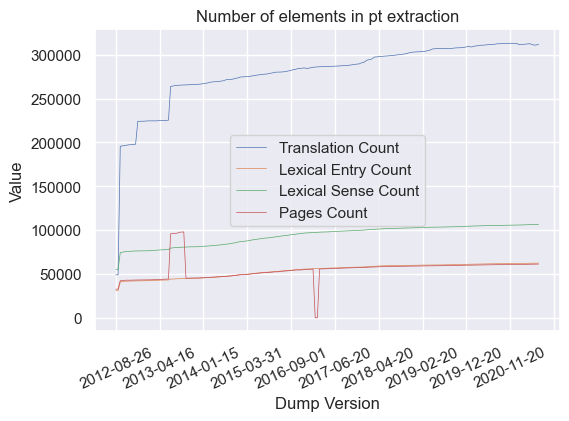

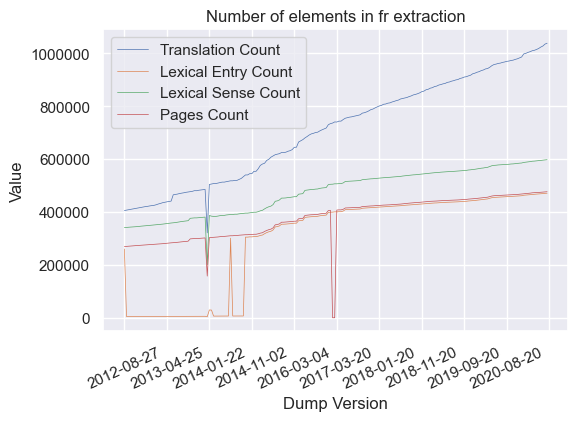

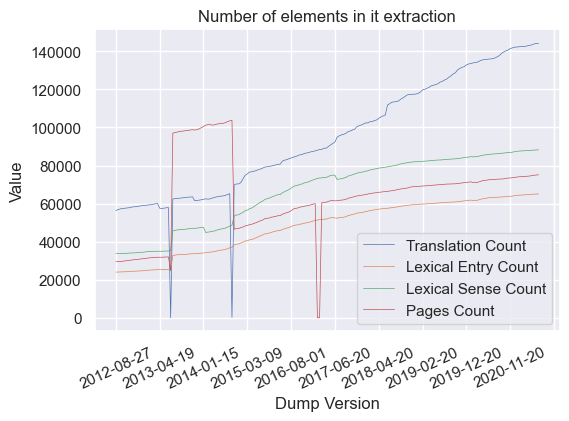

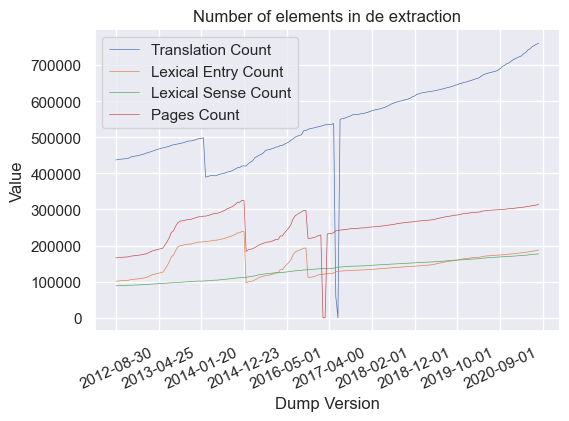

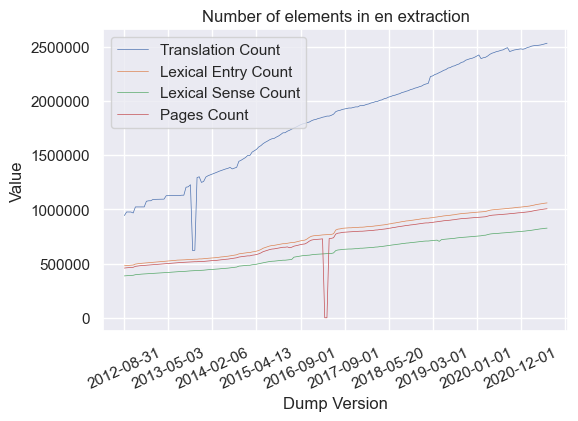

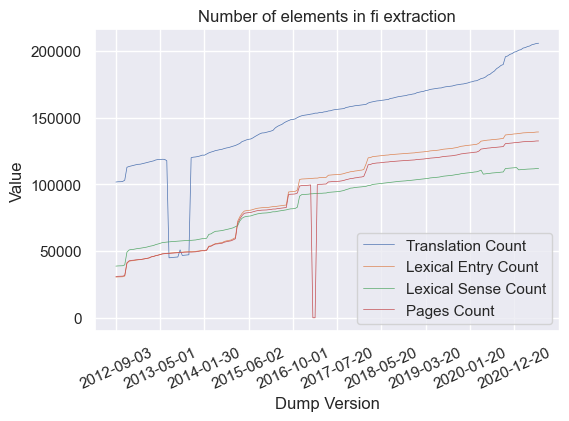

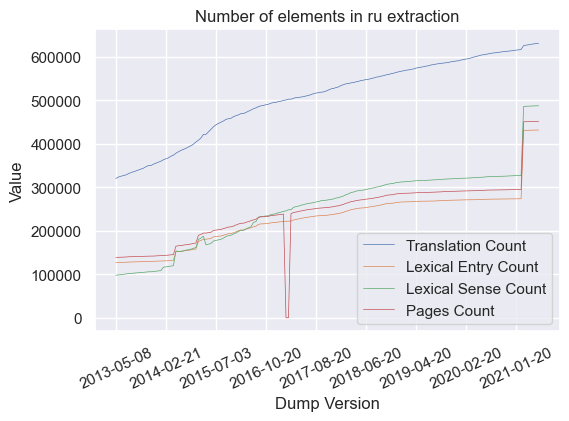

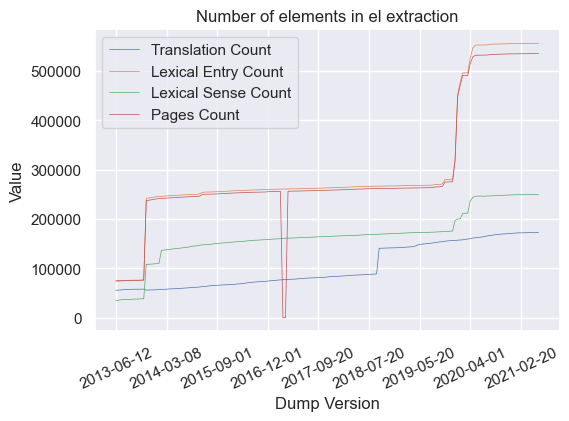

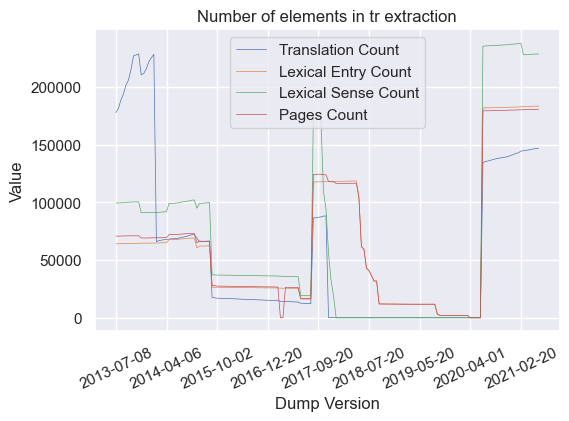

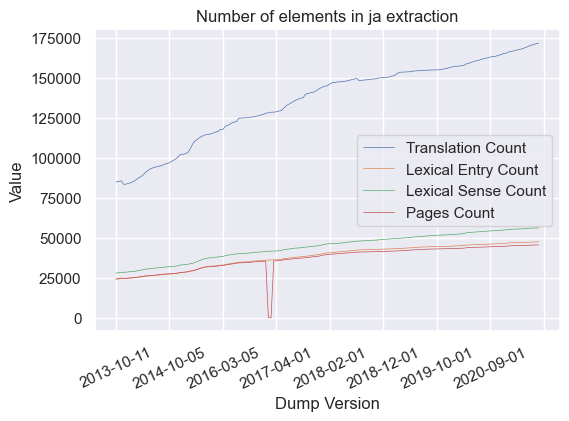

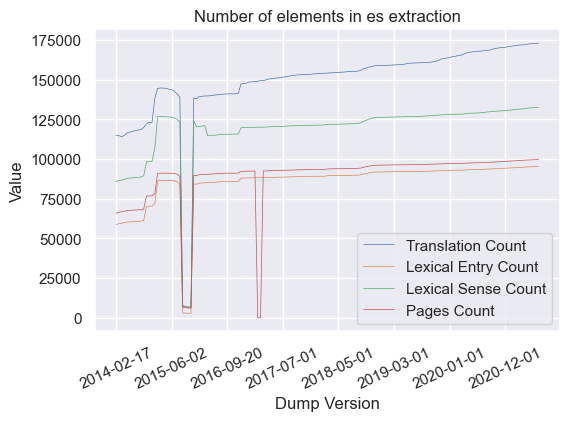

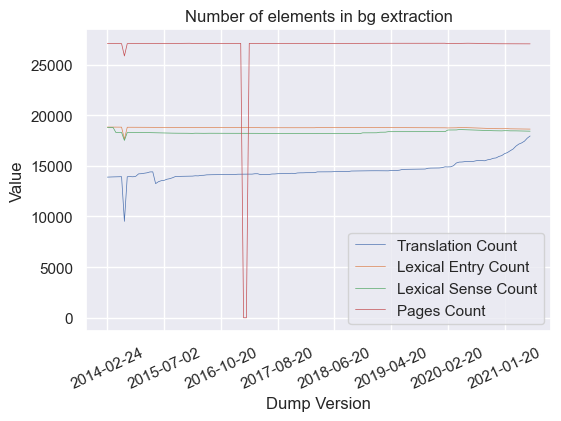

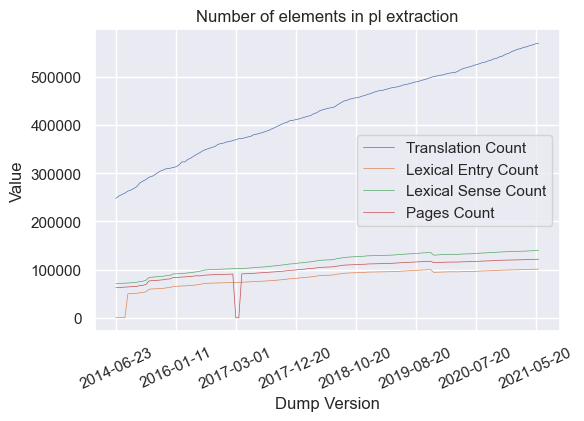

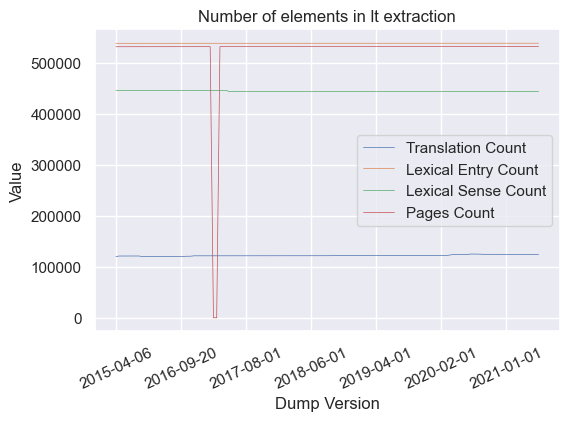

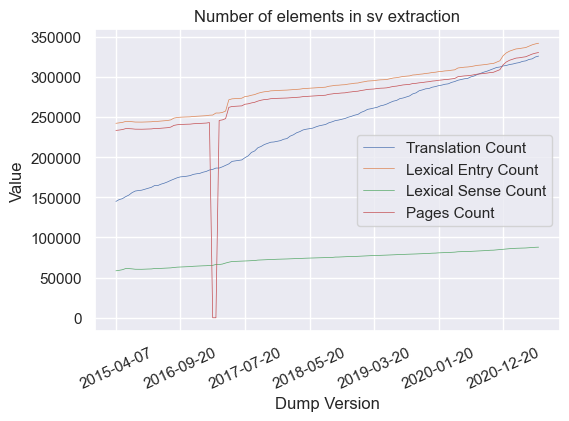

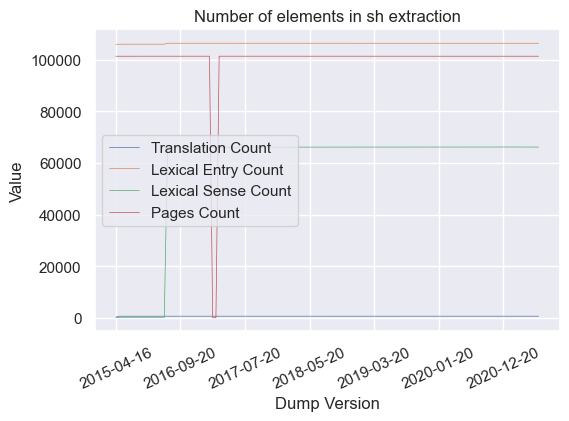

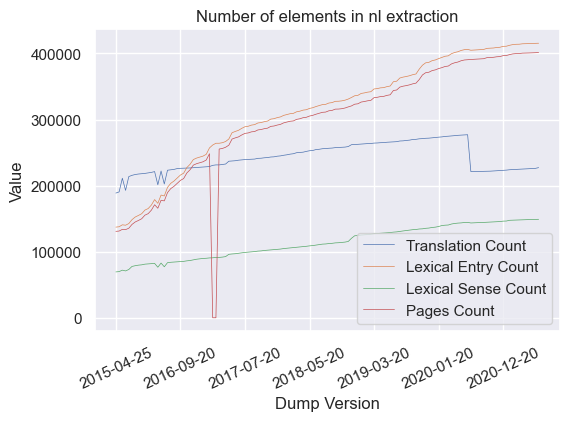

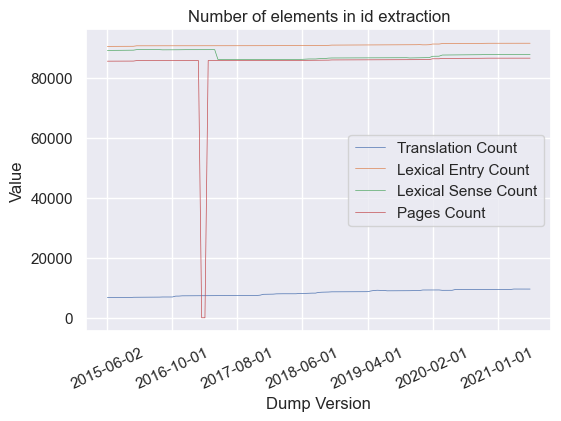

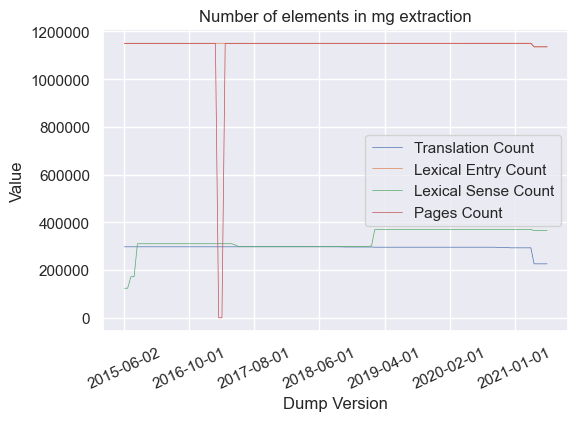

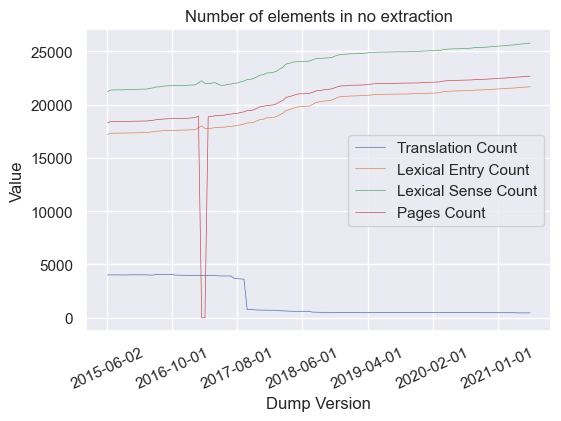

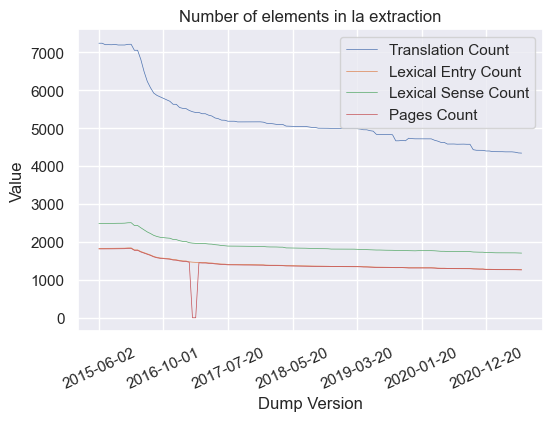

In [94]:
languages: list[str] = list(data["observationLanguage"].unique())
for language in languages:
    fig = plt.figure(dpi = 100)
    ax = sns.lineplot(data = data[data["observationLanguage"] == language], x = "wiktionaryDumpVersion", y = "translationsCount", linewidth = 0.5, label = "Translation Count")
    ax = sns.lineplot(data = data[data["observationLanguage"] == language], x = "wiktionaryDumpVersion", y = "lexicalEntryCount", linewidth = 0.5, label = "Lexical Entry Count")
    ax = sns.lineplot(data = data[data["observationLanguage"] == language], x = "wiktionaryDumpVersion", y = "lexicalSenseCount", linewidth = 0.5, label = "Lexical Sense Count")
    ax = sns.lineplot(data = data[data["observationLanguage"] == language], x = "wiktionaryDumpVersion", y = "pageCount", linewidth = 0.5, label = "Pages Count")
    plt.title(f"Number of elements in {language} extraction")
    plt.xticks(rotation = 25)
    plt.legend()
    plt.ylabel("Value")
    plt.xlabel("Dump Version")
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.ticklabel_format(axis='y', style='plain')